# Counting legal moves


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import trange

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Download data (Google Colab only)

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

# !cp '/content/drive/MyDrive/Colab Notebooks/grids.tar.gz' .
# !cp '/content/drive/MyDrive/Colab Notebooks/moves.tar.gz' .

# !mkdir data models
# !tar -xf grids.tar.gz --directory data/
# !tar -xf moves.tar.gz --directory data/

## Mini-batches

Batches are imported from the data folder.

The label $y$ is related to the number of legal moves $N$ by the equation
$$
    y = \frac{N}{N + 5}
$$
so that it is equal to zero if there are no moves, and approaches one if there are many moves.

In [5]:
def get_batch(index):
    x = torch.from_numpy(np.load('data/grids_%05d.npy' % index)).unsqueeze(1).float().to(device)
    n = torch.from_numpy(np.load('data/moves_%05d.npy' % index)).unsqueeze(1).to(device)
    y = n / (n + 5.0)
    return x, y

In [6]:
x, y = get_batch(0)
x.shape, y.shape

(torch.Size([200, 1, 96, 96]), torch.Size([200, 1]))

In [7]:
def visualize(x):
    return Image.fromarray(~np.array(torch.squeeze(x).cpu()).astype(bool))

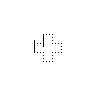

In [8]:
visualize(x[0])

In [9]:
y[0]

tensor([0.8333])

In [10]:
5.0 * y[0] / (1.0 - y[0])

tensor([25.0000])

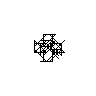

In [11]:
visualize(x[1])

In [12]:
y[1]

tensor([0.7917])

In [13]:
5.0 * y[1] / (1.0 - y[1])

tensor([19.0000])

Distribution of labels:

In [14]:
ydata = torch.cat([get_batch(i)[1].squeeze() for i in range(100)])
ndata = torch.round(5.0 * ydata / (1.0 - ydata))
nmax = ndata.max().int().item()
ndistribution = [torch.where(ndata == i, 1.0, 0.0).mean().item() for i in range(nmax + 1)]

In [15]:
ydata.mean(), ydata.std(), ydata.min(), ydata.max()

(tensor(0.6292), tensor(0.1924), tensor(0.), tensor(0.8684))

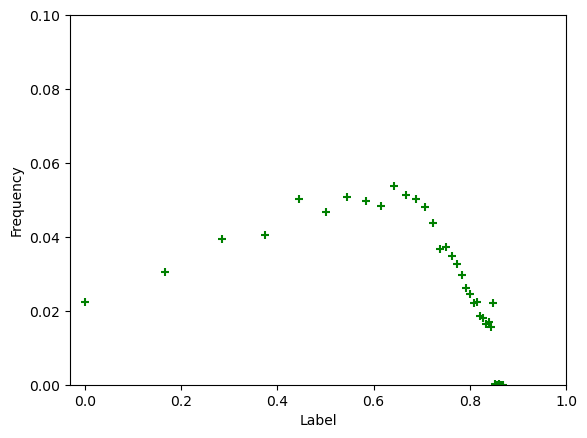

In [16]:
plt.scatter([y / (y + 5) for y in range(nmax + 1)], ndistribution, color='green', marker = '+')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xlim(-0.03, 1)
plt.ylim(0, 0.1)
plt.show()

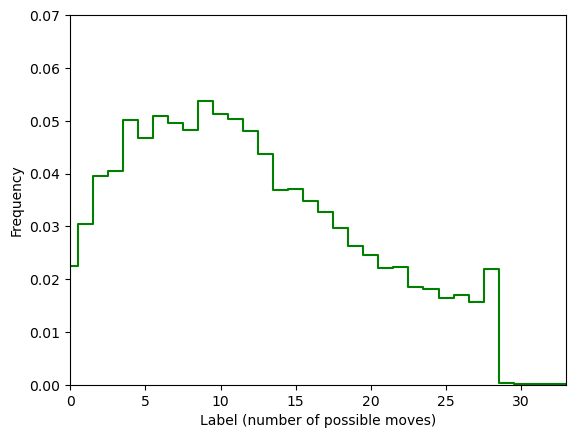

In [17]:
plt.step(np.array(range(nmax + 1)), ndistribution, where='mid', color='green')
plt.xlabel('Label (number of possible moves)')
plt.ylabel('Frequency')
plt.xlim(0, nmax)
plt.ylim(0, 0.07)
# plt.savefig('blog/Part_4_Counting_images/labels_counting.png', bbox_inches='tight')
plt.show()

### Data augmentation

In [18]:
def flip_grids(grids):
    return torch.flip(grids, dims=[-1])

In [19]:
def rotate_grids(grids, quarter_turns=1):
    match quarter_turns % 4:
        case 1:
            return torch.rot90(grids, dims=[-2,-1])
        case 2:
            return torch.flip(grids, dims=[-2,-1])
        case 3:
            return torch.rot90(grids, dims=[-1,-2])
        case _:
            return grids

In [20]:
def transform_grids(grids, seed):
    return rotate_grids(grids if seed % 8 < 4 else flip_grids(grids), seed)

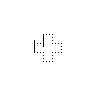

In [21]:
visualize(transform_grids(x,0)[0])

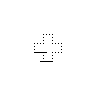

In [22]:
visualize(transform_grids(x,1)[0])

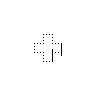

In [23]:
visualize(transform_grids(x,2)[0])

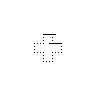

In [24]:
visualize(transform_grids(x,3)[0])

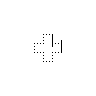

In [25]:
visualize(transform_grids(x,4)[0])

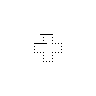

In [26]:
visualize(transform_grids(x,5)[0])

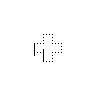

In [27]:
visualize(transform_grids(x,6)[0])

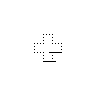

In [28]:
visualize(transform_grids(x,7)[0])

### Loss and accuracy

The accuracy is computed after inverting the relation between the label $y$ and the corresponding number of moves $N$:
$$
N = \frac{5 y}{1 - y}
$$
The value $N_\text{output}$ computed from the network output is rounded to the nearest integer, and compared with the label $N_\text{label}$ (also rounded to nearest integer to avoid numerical inaccuracies). The function `accuracy` counts how many times the two integer match. The functions `plusminusone` and `plusminustwo` count how many times $N_\text{output}$ and $N_\text{label}$ differ at most by one or two units.

In [29]:
def accuracy(outputs, labels, plusminus = 0.0):
    noutputs = torch.round(5.0 * outputs / (1.0 - outputs))
    nlabels = torch.round(5.0 * labels / (1.0 - labels))
    return torch.where(torch.abs(noutputs - nlabels) <= plusminus, 1.0, 0.0).mean()

In [30]:
def plusminusone(outputs, labels):
    return accuracy(outputs, labels, plusminus = 1.0)
def plusminustwo(outputs, labels):
    return accuracy(outputs, labels, plusminus = 2.0)

The loss function is chosen to be the mean square error in terms of the variable $N$, i.e.
$$
    L \approx \sum_i (N_\text{output} - N_\text{label})^2
    \propto
    \sum_i  \left( \frac{y_\text{output}}{1 - y_\text{output}} - \frac{y_\text{label}}{1 - y_\text{label}} \right)^2
$$
However, to avoid the divergence when $y_\text{output} = 1$, we use the following variant:
$$
    L = \sum_i \left( \frac{y_\text{output} - y_\text{label}}{1 - y_\text{label}} \right)^2
$$

In [31]:
def nloss(outputs, labels):
    return torch.square((outputs - labels) / (1.0 - labels)).mean()

## Model and training

In [32]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 20, stride = 3, kernel_size = 3, padding = 0), # output 32 x 32 pixels
    torch.nn.ReLU(),
    torch.nn.Conv2d(20, 40, stride = 1, kernel_size = 2, padding = 0), # output 31 x 31 pixels
    torch.nn.ReLU(),
    torch.nn.Conv2d(40, 40, stride = 1, kernel_size = 2, padding = 0), # output 30 x 30 pixels
    torch.nn.ReLU(),
    torch.nn.Conv2d(40, 40, stride = 1, kernel_size = 2, padding = 0), # output 29 x 29 pixels
    torch.nn.ReLU(),
    torch.nn.Conv2d(40, 40, stride = 1, kernel_size = 2, padding = 0), # output 28 x 28 pixels
    torch.nn.ReLU(),
    torch.nn.AdaptiveAvgPool2d(1),
    torch.nn.Flatten(),
    torch.nn.Linear(40, 20),
    torch.nn.ReLU(),
    torch.nn.Linear(20, 10),
    torch.nn.ReLU(),
    torch.nn.Linear(10, 1)
).to(device)

We use *transfer learning*: instead of training the model from scratch (which seems nearly impossible), we use a model pre-trained on the binary problem:

In [33]:
# net = torch.load('models/Descartes_binary.pt').to(device)
# net.train()
# net

**Possible modification:** we could also try to freeze all parameters of the convolutional layers and only train the last 3 linear layers (this does not seem to work though)

In [34]:
# for i in range(10):
#     for param in net[i].parameters():
#         param.requires_grad = False

**Other possible modification:** we could also modify the linear layer part of the network:

In [35]:
# modules = [net[i] for i in range(12)]
# modules.extend([torch.nn.Linear(40, 10),
#                 torch.nn.ReLU(),
#                 torch.nn.Linear(10, 4),
#                 torch.nn.ReLU(),
#                 torch.nn.Linear(4, 1)])
# net = torch.nn.Sequential(*modules)
# net

Number of parameters in the model:

In [36]:
sum(p.numel() for p in net.parameters())

23801

Number of trainable parameters in the model (only relevant with freezing):

In [37]:
# sum(p.numel() for p in net.parameters() if p.requires_grad)

In [38]:
y_pred = net(x)
y_pred.shape

torch.Size([200, 1])

In [39]:
nloss(y_pred, y)

tensor(8.9193, grad_fn=<MeanBackward0>)

In [40]:
accuracy(y_pred, y), plusminusone(y_pred, y), plusminustwo(y_pred, y)

(tensor(0.0400), tensor(0.0550), tensor(0.1050))

## Training

In [39]:
running_loss_data = []
running_accuracy_data = []
running_plusminusone_data = []
running_plusminustwo_data = []

Remark: in this case we changed optimizer from SGD to Adam

In [40]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001)

In [41]:
epoch_size = 2400
n_epochs = 100
log_cycle = 100

running_loss = []
running_accuracy = []
running_plusminusone = []
running_plusminustwo = []

for i in trange(n_epochs * epoch_size + 1):
    inputs, labels = get_batch(i % epoch_size)
    inputs = transform_grids(inputs, i)
    optimizer.zero_grad()
    outputs = net(inputs)
    loss = nloss(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss.append(loss.item())
    running_accuracy.append(accuracy(outputs, labels).item())
    running_plusminusone.append(plusminusone(outputs, labels).item())
    running_plusminustwo.append(plusminustwo(outputs, labels).item())

    if i % log_cycle == 0:
        running_loss_data.append(np.mean(running_loss))
        running_accuracy_data.append(np.mean(running_accuracy))
        running_plusminusone_data.append(np.mean(running_plusminusone))
        running_plusminustwo_data.append(np.mean(running_plusminustwo))

        print('[%6d] loss: %8.5f  accuracy: %4.2f %4.2f %4.2f' %
              (i, running_loss_data[-1], running_accuracy_data[-1],
               running_plusminusone_data[-1], running_plusminustwo_data[-1]))

        torch.save(net, 'models/Descartes_temp_%05d' % (i / log_cycle))

        running_loss = []
        running_accuracy = []
        running_plusminusone = []
        running_plusminustwo = []

  0%|          | 0/240001 [00:00<?, ?it/s]

[     0] loss: 13.49772  accuracy: 0.00 0.04 0.05
[   100] loss:  2.49621  accuracy: 0.03 0.08 0.13
[   200] loss:  0.18750  accuracy: 0.03 0.10 0.16
[   300] loss:  0.11853  accuracy: 0.05 0.16 0.27
[   400] loss:  0.09978  accuracy: 0.08 0.24 0.38
[   500] loss:  0.09887  accuracy: 0.08 0.24 0.39
[   600] loss:  0.09796  accuracy: 0.08 0.25 0.40
[   700] loss:  0.10003  accuracy: 0.08 0.23 0.37
[   800] loss:  0.09558  accuracy: 0.09 0.25 0.41
[   900] loss:  0.08083  accuracy: 0.09 0.28 0.44
[  1000] loss:  0.06218  accuracy: 0.12 0.33 0.52
[  1100] loss:  0.05203  accuracy: 0.13 0.38 0.58
[  1200] loss:  0.04809  accuracy: 0.13 0.39 0.60
[  1300] loss:  0.04222  accuracy: 0.15 0.43 0.64
[  1400] loss:  0.04028  accuracy: 0.16 0.44 0.65
[  1500] loss:  0.03954  accuracy: 0.15 0.43 0.64
[  1600] loss:  0.03694  accuracy: 0.16 0.44 0.66
[  1700] loss:  0.03778  accuracy: 0.16 0.44 0.66
[  1800] loss:  0.03463  accuracy: 0.16 0.45 0.68
[  1900] loss:  0.03121  accuracy: 0.18 0.50 0.72


In [42]:
# torch.save(net, 'models/Descartes_counting.pt')

In [41]:
# !cp models/Descartes_counting.pt '/content/drive/MyDrive/Colab Notebooks/'

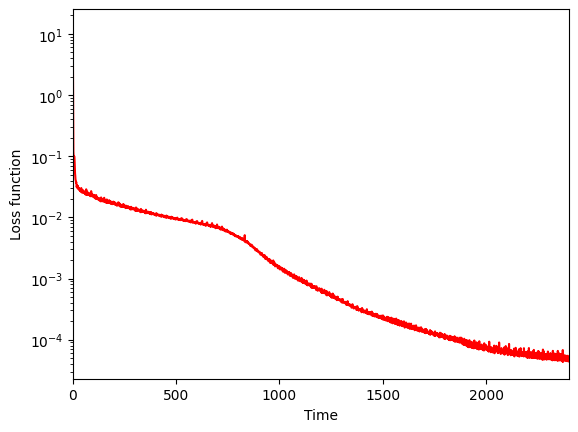

In [47]:
plt.plot(running_loss_data, color='red')
plt.xlabel('Time')
plt.xlim(0, len(running_loss_data) - 1)
plt.ylabel('Loss function')
plt.yscale('log')
# plt.savefig('Descartes_loss.png', bbox_inches='tight')
plt.show()

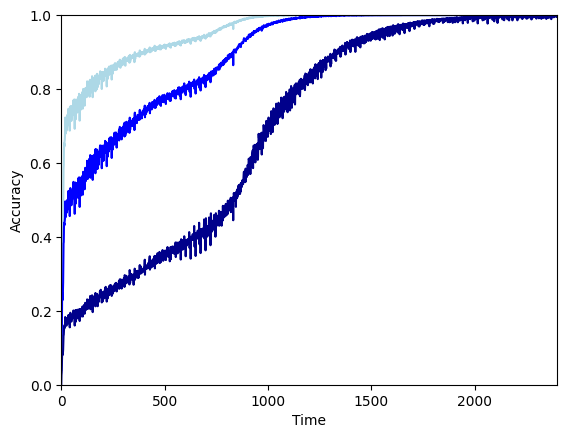

In [48]:
plt.plot(running_plusminustwo_data, color='lightblue')
plt.plot(running_plusminusone_data, color='blue')
plt.plot(running_accuracy_data, color='darkblue')
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.xlim(0, len(running_accuracy_data) - 1)
plt.ylim(0, 1)
# plt.savefig('Descartes_accuracy.png', bbox_inches='tight')
plt.show()

In [50]:
error_data = [1.0 - data for data in running_accuracy_data]
error_plusminusone_data = [1.0 - data for data in running_plusminusone_data]
error_plusminustwo_data = [1.0 - data for data in running_plusminustwo_data]

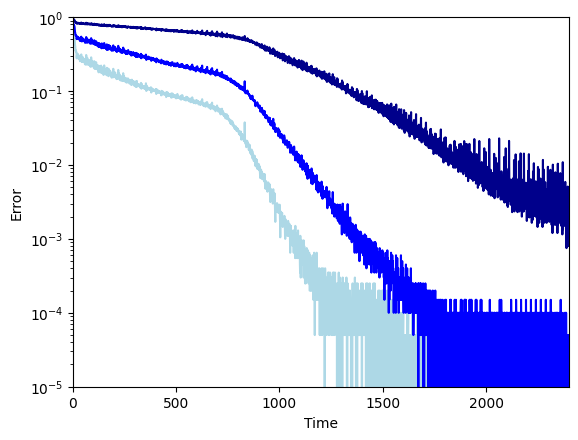

In [52]:
plt.plot(error_plusminustwo_data, color='lightblue')
plt.plot(error_plusminusone_data, color='blue')
plt.plot(error_data, color='darkblue')
plt.xlabel('Time')
plt.xlim(0, len(error_data) - 1)
plt.ylabel('Error')
plt.ylim(1e-5,1)
plt.yscale('log')
# plt.savefig('Descartes_error.png', bbox_inches='tight')
plt.show()

## Loading the model

Once the model has been trained, this can be used to load its state dictionary:

In [43]:
net2 = torch.load('models/Descartes_counting.pt', map_location=device)
net2.eval()

Sequential(
  (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(3, 3))
  (1): ReLU()
  (2): Conv2d(20, 40, kernel_size=(2, 2), stride=(1, 1))
  (3): ReLU()
  (4): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (5): ReLU()
  (6): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (7): ReLU()
  (8): Conv2d(40, 40, kernel_size=(2, 2), stride=(1, 1))
  (9): ReLU()
  (10): AdaptiveAvgPool2d(output_size=1)
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=40, out_features=20, bias=True)
  (13): ReLU()
  (14): Linear(in_features=20, out_features=10, bias=True)
  (15): ReLU()
  (16): Linear(in_features=10, out_features=1, bias=True)
)

In [44]:
# x, y = get_batch(0)

In [ ]:
# torch.onnx.export(net2, x, 'models/Descartes.onnx', export_params=True, input_names=["images"], output_names=["branches_count"],  dynamic_axes={'images' : {0 : 'batch_size'}, 'branches_count' : {0 : 'batch_size'}})

In [ ]:
# x.shape

## Validation

In [55]:
x = []
y = []
y_preds = []
for i in trange(2400, 2500):
    xi, yi = get_batch(i)
    x.append(xi)
    y.append(yi)
    y_preds.append(net2(xi))
x = torch.cat(x)
y = torch.cat(y)
y_preds = torch.cat(y_preds)
x.shape, y.shape, y_preds.shape

  0%|          | 0/100 [00:00<?, ?it/s]

(torch.Size([20000, 1, 96, 96]),
 torch.Size([20000, 1]),
 torch.Size([20000, 1]))

In [60]:
accuracy(y_preds, y)

tensor(0.9992)

In [61]:
plusminusone(y_preds, y)

tensor(0.9998)

In [62]:
plusminustwo(y_preds, y)

tensor(0.9999)

In [63]:
y.mean(), y.std(), y_preds.mean(), y_preds.std()

(tensor(0.6284),
 tensor(0.1918),
 tensor(0.6285, grad_fn=<MeanBackward0>),
 tensor(0.1920, grad_fn=<StdBackward0>))

In [64]:
n = 5.0 * y / (1.0 - y)
n_preds = 5.0 * y_preds / (1.0 - y_preds)
n[0:10], n_preds[0:10]

(tensor([[12.0000],
         [17.0000],
         [12.0000],
         [15.0000],
         [10.0000],
         [ 0.0000],
         [16.0000],
         [ 8.0000],
         [ 2.0000],
         [ 9.0000]]),
 tensor([[1.2184e+01],
         [1.7109e+01],
         [1.2038e+01],
         [1.5082e+01],
         [9.9183e+00],
         [8.1831e-04],
         [1.5980e+01],
         [8.1779e+00],
         [2.0171e+00],
         [9.0350e+00]], grad_fn=<SliceBackward0>))

In [65]:
mistakes = [i for i in range(y.shape[0])
            if torch.abs(n[i] - n_preds[i]) >= 0.5]

In [68]:
mistakes

[166,
 726,
 1091,
 2524,
 2568,
 3243,
 3319,
 5428,
 6162,
 8160,
 8326,
 10095,
 10964,
 17279,
 19997]

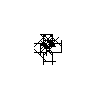

In [70]:
visualize(x[mistakes[0]])

In [71]:
n[mistakes[0]], n_preds[mistakes[0]]

(tensor([30.]), tensor([30.6635], grad_fn=<SelectBackward0>))

In [74]:
[(n[i], n_preds[i]) for i in mistakes]

[(tensor([30.]), tensor([30.6635], grad_fn=<SelectBackward0>)),
 (tensor([30.]), tensor([30.5641], grad_fn=<SelectBackward0>)),
 (tensor([17.0000]), tensor([17.5868], grad_fn=<SelectBackward0>)),
 (tensor([12.0000]), tensor([12.5024], grad_fn=<SelectBackward0>)),
 (tensor([29.0000]), tensor([29.5761], grad_fn=<SelectBackward0>)),
 (tensor([29.0000]), tensor([29.5312], grad_fn=<SelectBackward0>)),
 (tensor([30.]), tensor([30.7243], grad_fn=<SelectBackward0>)),
 (tensor([31.0000]), tensor([32.5151], grad_fn=<SelectBackward0>)),
 (tensor([31.0000]), tensor([31.7370], grad_fn=<SelectBackward0>)),
 (tensor([8.0000]), tensor([7.4393], grad_fn=<SelectBackward0>)),
 (tensor([17.0000]), tensor([17.5767], grad_fn=<SelectBackward0>)),
 (tensor([34.0000]), tensor([36.8700], grad_fn=<SelectBackward0>)),
 (tensor([17.0000]), tensor([17.6531], grad_fn=<SelectBackward0>)),
 (tensor([33.0000]), tensor([34.8562], grad_fn=<SelectBackward0>)),
 (tensor([30.]), tensor([30.8176], grad_fn=<SelectBackward0>))

## Inference

To verify how good the model is, we can test it on a type of grid that it has never seen before:

In [75]:
import sys
sys.path.append(sys.path[0] + '/../cpp/bin')

import PyMorpionSolitaire

In [106]:
game = PyMorpionSolitaire.Game5T('p')
x = torch.tensor(game.image()[48:144, 48:144]).float().unsqueeze(0).unsqueeze(0).to(device)
n = game.getNumberOfMoves()

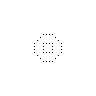

In [107]:
visualize(x)

In [108]:
n

24

In [109]:
y = net2(x).data
5.0 * y / (1.0 - y)

tensor([[24.4506]])

In [110]:
game.playAtRandom(10)
x = torch.tensor(game.image()[48:144, 48:144]).float().unsqueeze(0).unsqueeze(0).to(device)
n = game.getNumberOfMoves()

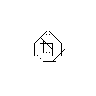

In [111]:
visualize(x)

In [112]:
n

9

In [113]:
y = net2(x).data
5.0 * y / (1.0 - y)

tensor([[8.8333]])